# Proyecto Final

Integrantes:
- Kroko
- Alan
- Nandy

### Enunciado

En este proyecto tendrá que trabajar con datos reales del departamento de la policía de la ciudad de nueva york y se enmarca en el contexto de seguridad y criminalidad en los barrios de la ciudad. **El objetivo de este proyecto es predecir la cantidad de delitos cada cierto tipo por barrio.**





El conjunto de datos a utilizar proviene de la página de datos abiertos de la ciudad de NY. (https://opendata.cityofnewyork.us) y comprenden datos desde el 2013 hasta el 2020 de arrestos, colisiones vehiculares y denuncias ciudadanas.

El dataset contiene diversos registros de distintos tipos de crimenes, en este estudio debe centrarse en los siguientes:
1. Delitos (Felonies)
2. Faltas (Misdemeanors)
3. Violaciones (Violations)

Esta categorización puede ser encontrada en la variable "LAW_CAT_CD"

Los barrios de estudio son:
- Staten Island
- Brooklyn
- Queens
- Manhattan
- Bronx

### Requerimientos



1. Seleccione al menos dos barrios de la ciudad y obtenga estimaciones de la cantidad de delitos, por tipo, ocurridos en la ciudad de NY semana a semana usando como conjunto de entrenamiento toda la data hasta el 2019 y como conjunto de pruebas el año 2020 completo. Compare distintas aproximaciones de modelamiento utilizando las métricas y modelos vistos en clases aunque se permite tambien usar métricas/modelos no discutidos (siempre y cuando se utilicen de manera correcta).
2. Deberá almacenar la informacion en una base de datos Postgres con el esquema de datos que usted prefiera
3. Utilizando Apache Airflow, cree un DAG que contenga al menos las siguientes tasks:
    - Data Processing: Extraerá la informacion de la based de datos Postgres
    - Data Processing: Procesará la informacióin extraida en la etapa anterior realizando todas las tareas de ingeniería de atributos que usted estime conveniente para sus modelos
    - Model Training: Utilizando la información generada en el punto anterior esta tasa debe ajustar los modelos a la data histórica con los hiperparámetros y configuración que usted haya estimado conveniente de su experimentación previa, una vez finalizado el entrenamiento debe almacenar el modelo donde usted estime conveniente. Este paso se debe realizar solo si no existe un modelo previamente entrenado, en cuyo caso se debe omitir este paso y pasar directamente al siguiente.
    - Model Inference: Utilizando un modelo ya entrenado, realice inferencias sobre el conjunto de pruebas y estas sean guardadas en una tabla de postgres.

4. Genere un informe breve donde se explique la metodología que utilizó para realizar los modelos justificando las decisiones tomadas a partir de lo observado en la experimientación. Explique tambien la infraestructura y el DAG generado.

### Consideraciones:


- Se recomienda realizar la experimentación sobre los datos en Jupyter para determinar la mejor configuración de los modelos de series de tiempo, una vez que haya obtenido un modelo con resultados satisfactorios incluya esta configuración en la tasa de Model Training.
- Sus modelos deben hacer predicciones a nivel semana, es decir, debe ser capaz de entregar para cada semana del 2020 disponible en los datos la cantidad de delitos de cada tipo que ocurrirán por barrio.
- Note que no se especificó la forma en que se debe pasar la informacion de una task a la siguiente, esto queda a criterio del equipo ya que hay muchas formas de hacerlo. Estudie e investigue cual es la que más le conviene para su caso o considear que es correcta. Lo mismo para el modelo en si.
- El entregable subido a aula debe contener al menos el notebook con los experimentos realizados, al menos un archivo .py con la definicion del DAG/tasks, el informe en formato PDF, un dump de la base de datos en formato .sql con las tablas que haya utilizado ya pobladas junto con un archivo en formato .txt o .json con la información necesaria para conectarse a la base de datos, y en caso de ser necesario, el modelo entrenado.
- Puesto que le pide usar una base de datos para almacenar la informacion durante las tasks necesitará hacer una conexión desde Python a Postgres: Queda prohibido incluir información sensible sobre la conexión al motor en los archivos .py, se le sugiere crear un archivo de configuracion en formato .json  (o el que guste) y que este sea leido simplemente desde el codigo, demas esta decir que si usa alguna herramienta de versionamiento de codigo ese archivo no deberia ser subido aunque para los efectos de la tarea subalo junto con el resto de los entregables. 
- Entregar codigo con informacion sensible sobre las conexiones al motor incurrirá en descuentos de puntaje
- Algo que le sera util es usar Docker.
- Este proyecto puede ser realizado en grupos de máximo tres personas.

## Pregunta 1: 

Selección de barrios y exploración de datos

In [2]:
#%pip install pandas scikit-learn numpy seaborn matplotlib scipy statsmodels prophet plotly pmdarima

In [28]:
import pandas as pd
import sklearn
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

Seleccionamos del dataset aquellos registros de 2019 y 2020 para su posterior uso

In [3]:
# # ya que debemos ocupar el 2019 como entrenamiento, y el 2020 como prueba, vamos a sacar slices de la data.
# df = pd.read_csv("./Data/NYPD_Arrests_Data__Historic_.csv")
# df.head()
# df.shape

In [4]:
df["ARREST_DATE"] = pd.to_datetime(df["ARREST_DATE"])
df_2019 = df[(df["ARREST_DATE"].dt.year < 2007) or ((df["ARREST_DATE"].dt.year > 2007) and (df["ARREST_DATE"].dt.year <= 2019)) ]
df_2020 = df[df["ARREST_DATE"].dt.year == 2020]
df_2019.info()

In [5]:
# ## Lo guardamos en un CSV para su manipulación:

# df_2019.to_csv("./Data/NYPD_ARRESTS_DATA_2019.csv", index=False)
# df_2020.to_csv("./Data/NYPD_ARRESTS_DATA_2020.csv", index=False)

### EDA:

In [6]:
## Revisamos los datasets para Train y Test

df_2019 = pd.read_csv("./Data/NYPD_ARRESTS_DATA_2019.csv")
df_2020 = pd.read_csv("./Data/NYPD_ARRESTS_DATA_2020.csv")

print("Train data: ", df_2019.shape)
print("Test data: ",df_2020.shape)

Train data:  (4826310, 19)
Test data:  (140413, 19)


Data Cleaning:

In [7]:
print("Train missing values:")
print(df_2019.isnull().sum())
print()
print("Test missing values:")
print(df_2020.isnull().sum())
print()
print("Train duplicated: ", df_2019.duplicated().sum())
print("Test duplicated: ", df_2020.duplicated().sum())

Train missing values:
ARREST_KEY               0
ARREST_DATE              0
PD_CD                  238
PD_DESC               9000
KY_CD                 9000
OFNS_DESC             9000
LAW_CODE               173
LAW_CAT_CD           16958
ARREST_BORO              8
ARREST_PRECINCT          0
JURISDICTION_CODE        6
AGE_GROUP               17
PERP_SEX                 0
PERP_RACE                0
X_COORD_CD               1
Y_COORD_CD               1
Latitude                 1
Longitude                1
Lon_Lat                  1
dtype: int64

Test missing values:
ARREST_KEY              0
ARREST_DATE             0
PD_CD                  23
PD_DESC                37
KY_CD                  37
OFNS_DESC              37
LAW_CODE                0
LAW_CAT_CD           1389
ARREST_BORO             0
ARREST_PRECINCT         0
JURISDICTION_CODE       0
AGE_GROUP               0
PERP_SEX                0
PERP_RACE               0
X_COORD_CD              0
Y_COORD_CD              0
Latitude      

In [8]:
df_2019.dropna(subset=["LAW_CAT_CD"], inplace=True)
df_2020.dropna(subset=["LAW_CAT_CD"], inplace=True)

In [9]:
df_2019.dtypes

ARREST_KEY             int64
ARREST_DATE           object
PD_CD                float64
PD_DESC               object
KY_CD                float64
OFNS_DESC             object
LAW_CODE              object
LAW_CAT_CD            object
ARREST_BORO           object
ARREST_PRECINCT        int64
JURISDICTION_CODE    float64
AGE_GROUP             object
PERP_SEX              object
PERP_RACE             object
X_COORD_CD           float64
Y_COORD_CD           float64
Latitude             float64
Longitude            float64
Lon_Lat               object
dtype: object

In [10]:
# Convertiremos estos datos en algo legible a continuacion:

df_2019["LAW_CAT_CD"] = df_2019["LAW_CAT_CD"].replace({"F": "Felony", "M": "Misdemeanor", "V": "Violation"})
df_2020["LAW_CAT_CD"] = df_2020["LAW_CAT_CD"].replace({"F": "Felony", "M": "Misdemeanor", "V": "Violation"})
df_2019["ARREST_BORO"] = df_2019["ARREST_BORO"].replace({"B": "Bronx", "K": "Brooklyn", "M": "Manhattan", "Q": "Queens", "S": "Staten Island"})
df_2020["ARREST_BORO"] = df_2020["ARREST_BORO"].replace({"B": "Bronx", "K": "Brooklyn", "M": "Manhattan", "Q": "Queens", "S": "Staten Island"})

df_2019.head()


,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lon_Lat
0,32311380,2007-06-18,511.0,"CONTROLLED SUBSTANCE, POSSESSION 7",235.0,DANGEROUS DRUGS,PL 2200300,Misdemeanor,Queens,27,1.0,18-24,M,BLACK,NaN,NaN,NaN,NaN,NaN
1,192799737,2019-01-26,177.0,SEXUAL ABUSE,116.0,SEX CRIMES,PL 1306503,Felony,Manhattan,25,0.0,45-64,M,BLACK,1000555.0,230994.0,40.800694,-73.941109,POINT (-73.94110928599997 40.800694331000045)
2,193260691,2019-02-06,NaN,NaN,NaN,NaN,PL 2203400,Felony,Manhattan,14,0.0,25-44,M,UNKNOWN,986685.0,215375.0,40.757839,-73.991212,POINT (-73.99121211099998 40.75783900300007)
3,149117452,2016-01-06,153.0,RAPE 3,104.0,RAPE,PL 1302503,Felony,Brooklyn,67,0.0,25-44,M,BLACK,998032.0,175598.0,40.648650,-73.950336,POINT (-73.95033556299995 40.648650085000035)
4,190049060,2018-11-15,157.0,RAPE 1,104.0,RAPE,PL 1303501,Felony,Brooklyn,77,0.0,25-44,M,BLACK,1003606.0,185050.0,40.674583,-73.930222,POINT (-73.93022154099998 40.67458330800008)


Ahora si, la 1


In [11]:
train_data = df_2019.copy()
test_data = df_2020.copy()

# Convertimos la fecha en un formato legible para el modelo:
train_data['ARREST_DATE'] = pd.to_datetime(train_data['ARREST_DATE'])
test_data['ARREST_DATE'] = pd.to_datetime(test_data['ARREST_DATE'])

In [12]:


# Count arrests per week for train_data
train_arrest_count = train_data.groupby([pd.Grouper(key='ARREST_DATE', freq='W'), 'LAW_CAT_CD', 'ARREST_BORO']).size().reset_index(name='ARREST_COUNT')

# Count arrests per week for test_data
test_arrest_count = test_data.groupby([pd.Grouper(key='ARREST_DATE', freq='W'), 'LAW_CAT_CD', 'ARREST_BORO']).size().reset_index(name='ARREST_COUNT')

print(train_arrest_count.isnull().sum())

train_arrest_count.head()

ARREST_DATE     0
LAW_CAT_CD      0
ARREST_BORO     0
ARREST_COUNT    0
dtype: int64


,ARREST_DATE,LAW_CAT_CD,ARREST_BORO,ARREST_COUNT
0,2006-01-01,Felony,Bronx,35
1,2006-01-01,Felony,Brooklyn,43
2,2006-01-01,Felony,Manhattan,54
3,2006-01-01,Felony,Queens,28
4,2006-01-01,Felony,Staten Island,4


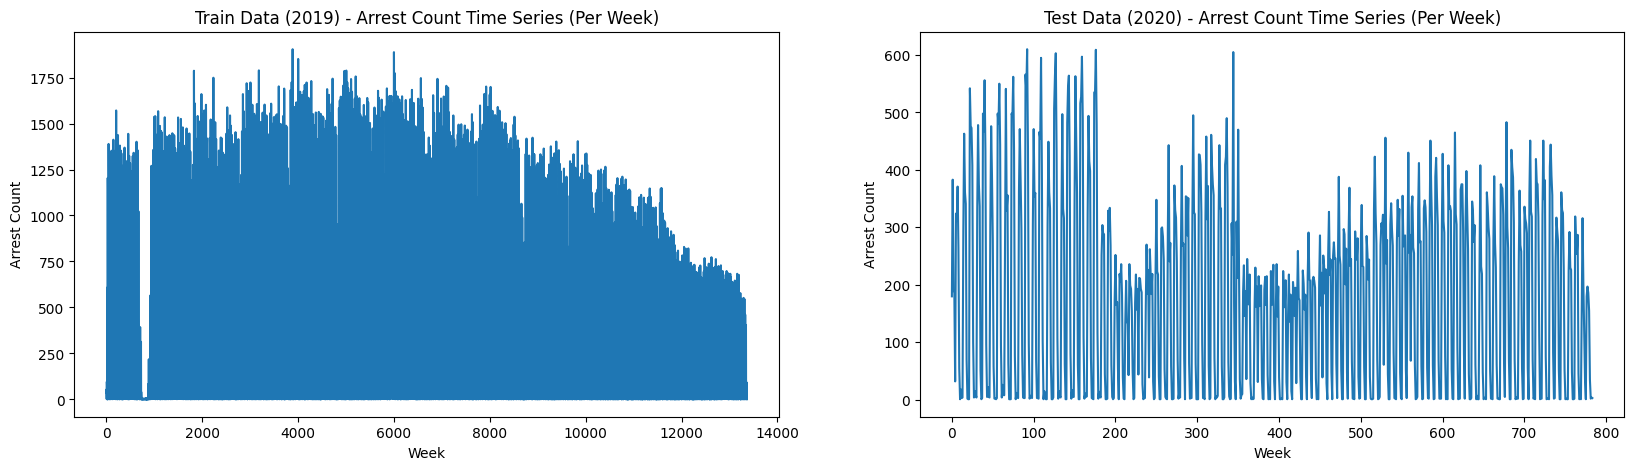

In [13]:
# Plot the time series for train_data
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].plot(train_arrest_count.index, train_arrest_count['ARREST_COUNT'])
axs[0].set_xlabel('Week')
axs[0].set_ylabel('Arrest Count')
axs[0].set_title('Train Data (2019) - Arrest Count Time Series (Per Week)')

# Plot the time series for test_data
axs[1].plot(test_arrest_count.index, test_arrest_count['ARREST_COUNT'])
axs[1].set_xlabel('Week')
axs[1].set_ylabel('Arrest Count')
axs[1].set_title('Test Data (2020) - Arrest Count Time Series (Per Week)')
plt.show()

C:\Users\n3mes\AppData\Local\Temp\ipykernel_25868\29431055.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_palette = plt.cm.get_cmap('tab10')


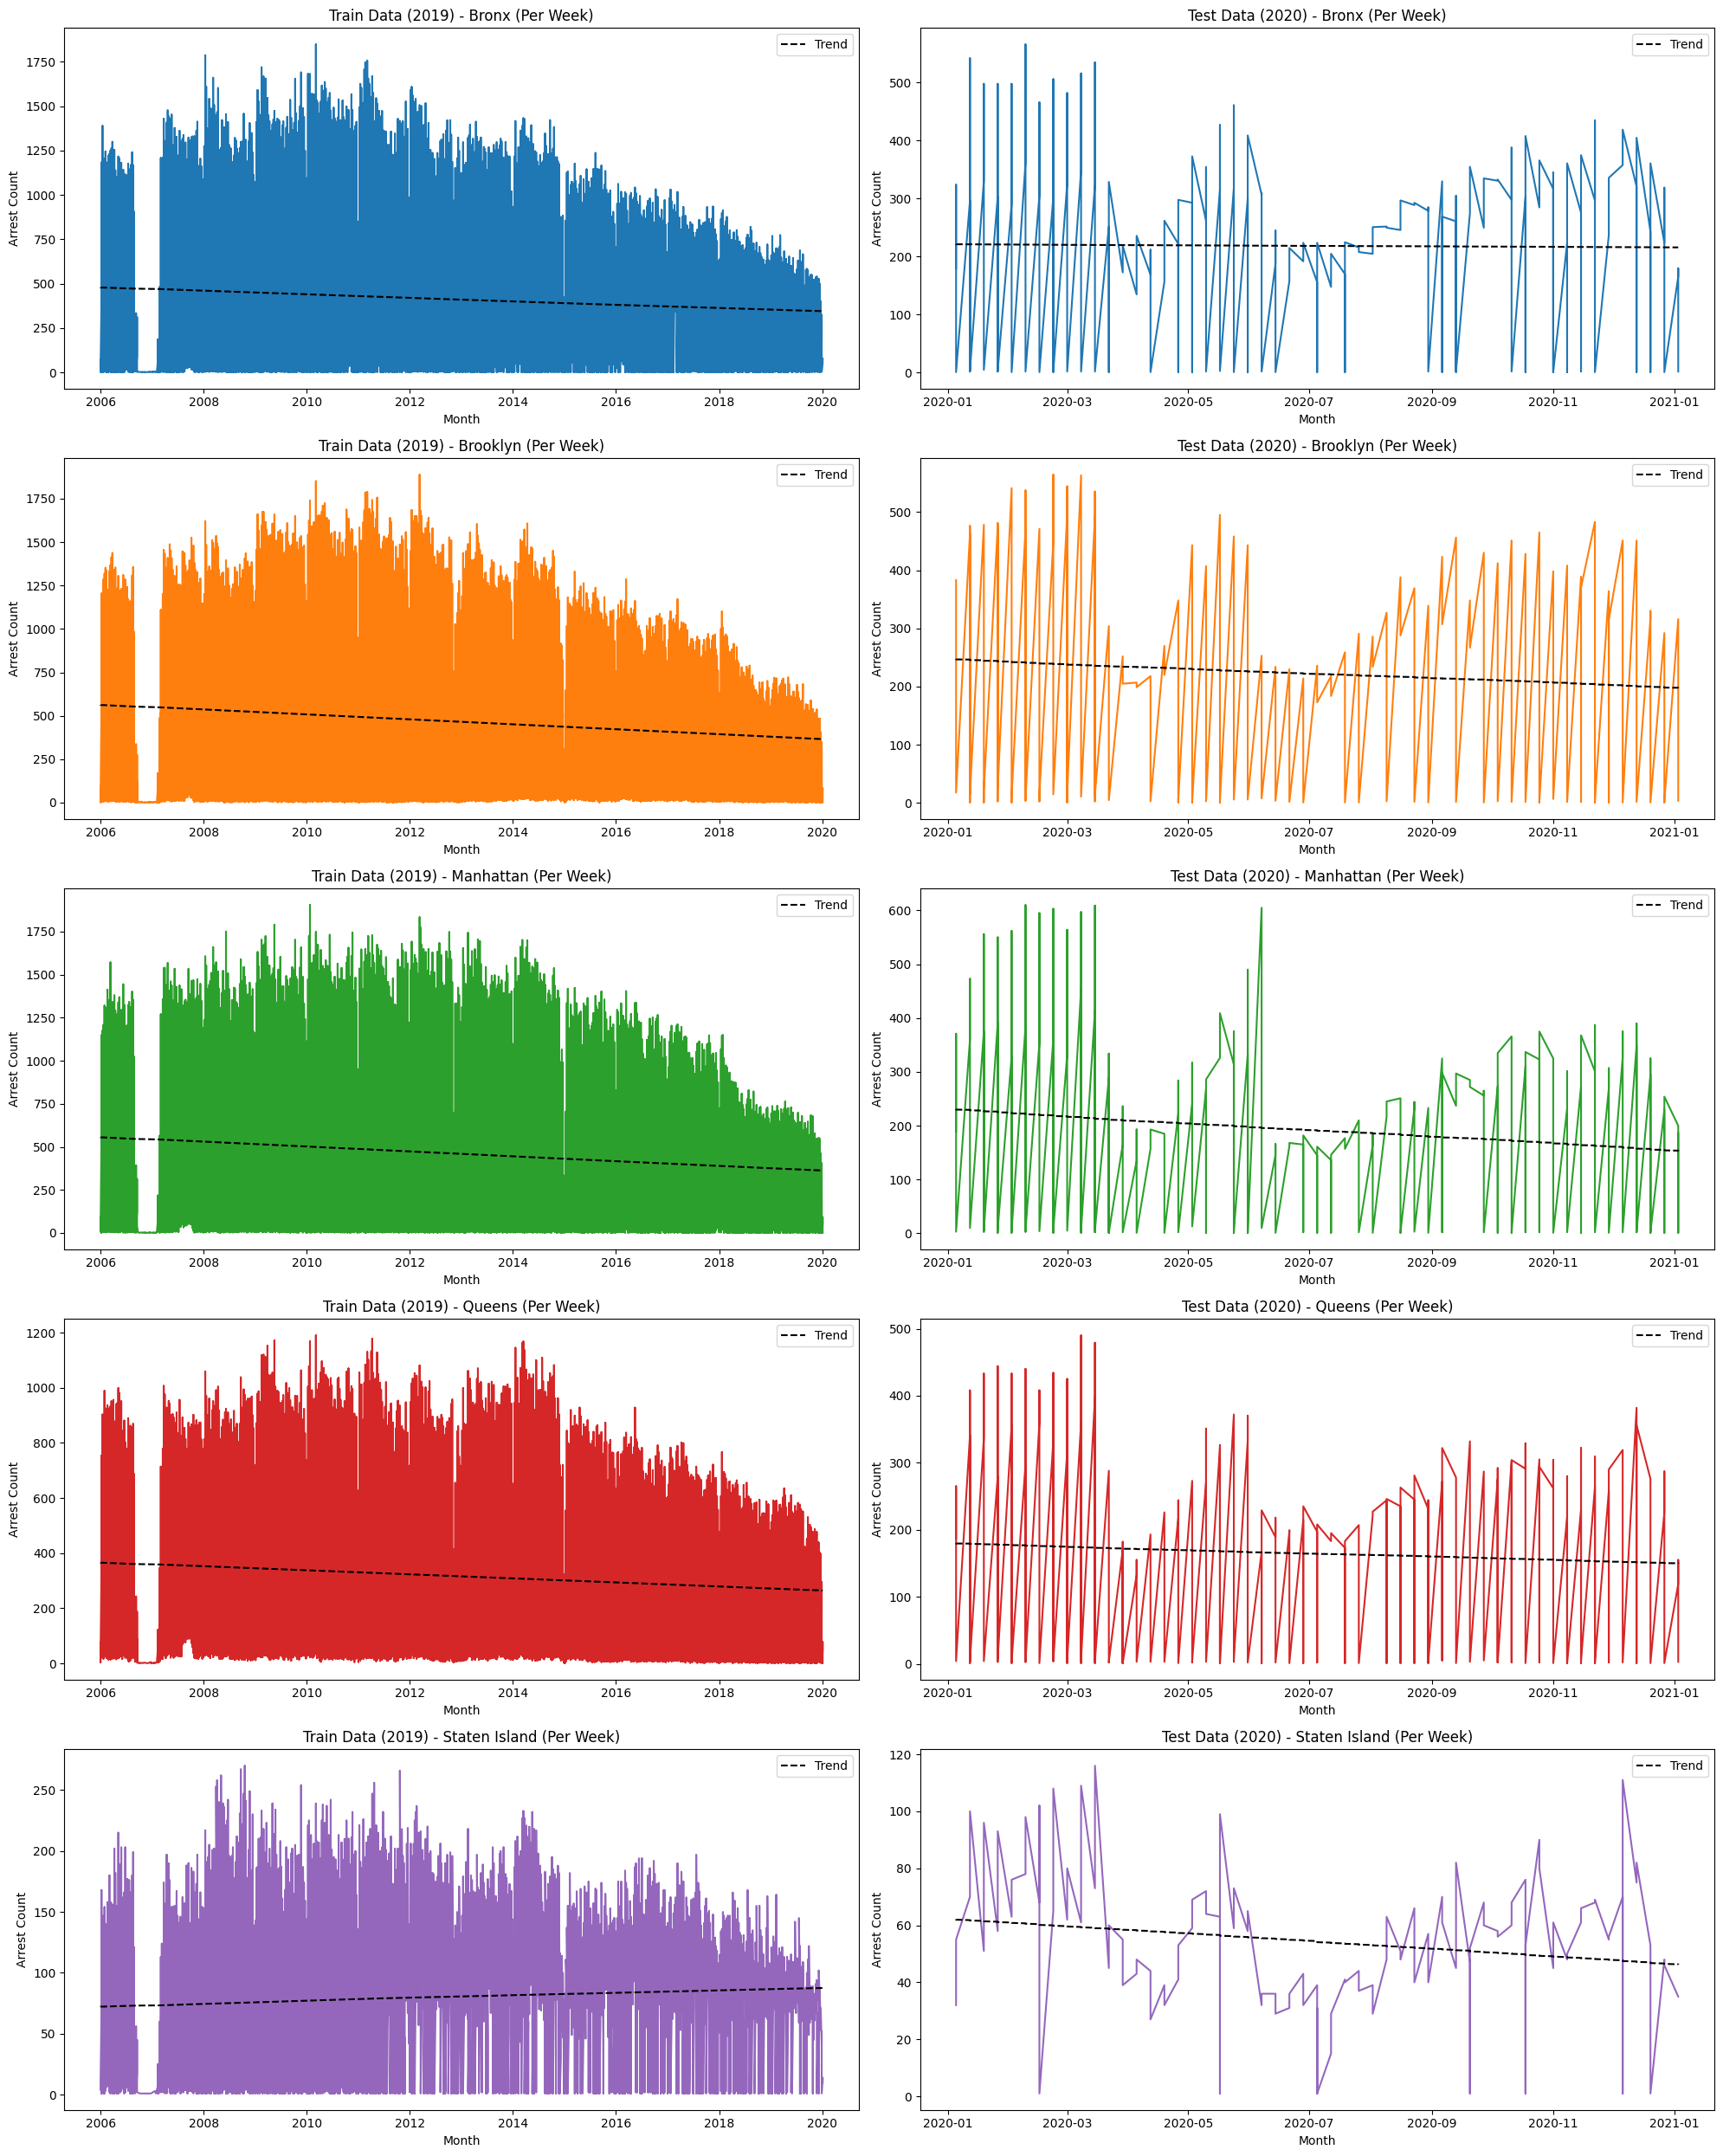

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Get unique boroughs from the train_data and test_data
boroughs_train = train_arrest_count['ARREST_BORO'].unique()
boroughs_test = test_arrest_count['ARREST_BORO'].unique()

# Define a color palette for the boroughs
color_palette = plt.cm.get_cmap('tab10')

# Create subplots with two columns for train_data and test_data
fig, axs = plt.subplots(len(boroughs_train), 2, figsize=(20, 5*len(boroughs_train)))

# Iterate over boroughs_train and plot the time series for each borough in the train_data column
for i, borough in enumerate(boroughs_train):
    train_data_borough = train_arrest_count[train_arrest_count['ARREST_BORO'] == borough]
    color = color_palette(i % 10)
    axs[i, 0].plot(train_data_borough['ARREST_DATE'], train_data_borough['ARREST_COUNT'], color=color)
    axs[i, 0].set_xlabel('Month')
    axs[i, 0].set_ylabel('Arrest Count')
    axs[i, 0].set_title(f'Train Data (2019) - {borough} (Per Week)')

    # Calculate the trend line using linear regression
    x = np.arange(len(train_data_borough))
    trend = np.polyfit(x, train_data_borough['ARREST_COUNT'], 1)
    trend_line = np.polyval(trend, x)
    
    axs[i, 0].plot(train_data_borough['ARREST_DATE'], trend_line, color='black', linestyle='--', label='Trend')

    axs[i, 0].legend()

# Iterate over boroughs_test and plot the time series for each borough in the test_data column
for i, borough in enumerate(boroughs_test):
    test_data_borough = test_arrest_count[test_arrest_count['ARREST_BORO'] == borough]
    color = color_palette(i % 10)
    axs[i, 1].plot(test_data_borough['ARREST_DATE'], test_data_borough['ARREST_COUNT'], color=color)
    axs[i, 1].set_xlabel('Month')
    axs[i, 1].set_ylabel('Arrest Count')
    axs[i, 1].set_title(f'Test Data (2020) - {borough} (Per Week)')

    # Calculate the trend line using linear regression
    x = np.arange(len(test_data_borough))
    trend = np.polyfit(x, test_data_borough['ARREST_COUNT'], 1)
    trend_line = np.polyval(trend, x)
    
    axs[i, 1].plot(test_data_borough['ARREST_DATE'], trend_line, color='black', linestyle='--', label='Trend')

    axs[i, 1].legend()

# Adjust the layout
plt.tight_layout()

# Show the plots
plt.show()



In [15]:
# %pip install statsmodels
# %pip install prophet

In [16]:
train_arrest_pivot = train_arrest_count.pivot(index='ARREST_DATE', columns=['LAW_CAT_CD', 'ARREST_BORO'], values='ARREST_COUNT')
test_arrest_pivot = test_arrest_count.pivot(index='ARREST_DATE', columns=['LAW_CAT_CD', 'ARREST_BORO'], values='ARREST_COUNT')


train_arrest_pivot = train_arrest_pivot.fillna(0)
test_arrest_pivot = test_arrest_pivot.fillna(0)

train_arrest_pivot.head()

LAW_CAT_CD  Felony                                                I         \
ARREST_BORO  Bronx Brooklyn Manhattan Queens Staten Island Brooklyn Queens   
ARREST_DATE                                                                  
2006-01-01    35.0     43.0      54.0   28.0           4.0      2.0    4.0   
2006-01-08   438.0    608.0     579.0  372.0          71.0      8.0   22.0   
2006-01-15   462.0    597.0     552.0  376.0          87.0      7.0   26.0   
2006-01-22   415.0    581.0     541.0  395.0          50.0      5.0   17.0   
2006-01-29   445.0    579.0     541.0  390.0          62.0     11.0   35.0   

LAW_CAT_CD  Misdemeanor                                         Violation  \
ARREST_BORO       Bronx Brooklyn Manhattan Queens Staten Island     Bronx   
ARREST_DATE                                                                 
2006-01-01         74.0     96.0      91.0   77.0          10.0       1.0   
2006-01-08       1183.0   1204.0    1149.0  754.0         168.0      18.0   
2006-01-15       1389.0   1208.0    1175.0  903.0         145.0      18.0   
2006-01-22       1167.0   1285.0    1208.0  849.0         147.0      12.0   
2006-01-29       1203.0   1318.0    1320.0  989.0         154.0      21.0   

LAW_CAT_CD                                I                          \
ARREST_BORO Brooklyn Manhattan Queens Bronx Manhattan Staten Island   
ARREST_DATE                                                           
2006-01-01       8.0       6.0   17.0   0.0       0.0           0.0   
2006-01-08     118.0     108.0   86.0   2.0       1.0           1.0   
2006-01-15      98.0     143.0   85.0   3.0       6.0           0.0   
2006-01-22     104.0     143.0  108.0   2.0       8.0           1.0   
2006-01-29     120.0     163.0  112.0   4.0       7.0           1.0   

LAW_CAT_CD      Violation  
ARREST_BORO Staten Island  
ARREST_DATE                
2006-01-01            0.0  
2006-01-08            1.0  
2006-01-15            4.0  
2006-01-22            4.0  
2006-01-29           11.0

## Analizando los Time Series

Usando ADFuller, estudiaremos los datos de cada serie temporal correspondiente a cada barrio y tipo de delito para determinar si son estacionarias o no.

Si el p-value es menor a 0.05, entonces podemos rechazar la hipótesis nula y decir que la serie es estacionaria con un 95% de confianza.

De lo contrario, si el p-value es mayor a 0.05, entonces no podemos rechazar la hipótesis nula y decir que la serie no es estacionaria.

In [17]:
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.api import ExponentialSmoothing

def ADF_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
    
def KPSS_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries.dropna(), regression="c", nlags="auto")    
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)
    
    
def analyze_stationarity(timeseries, title):
    fig, ax = plt.subplots(2, 1, figsize=(16, 8))

    rolmean = pd.Series(timeseries).rolling(window=7).mean() 
    rolstd = pd.Series(timeseries).rolling(window=7).std()
    ax[0].plot(timeseries, label= title)
    ax[0].plot(rolmean, label='rolling mean');
    ax[0].plot(rolstd, label='rolling std (x10)');
    ax[0].set_title('30-day window')
    ax[0].legend()

    

In [18]:
from statsmodels.tsa.stattools import adfuller

stationary = []

# Iterate over each borough and law category in train_arrest_pivot
for borough in train_arrest_pivot.columns.get_level_values('ARREST_BORO').unique():
    for law_cat_cd in train_arrest_pivot.columns.get_level_values('LAW_CAT_CD').unique():
        # Extract the data for the specific borough and law category
        data = train_arrest_pivot.xs((law_cat_cd, borough), level=('LAW_CAT_CD', 'ARREST_BORO'), axis=1)
        
        print(f'Borough: {borough}, Law Category: {law_cat_cd}')
        ADF_test(data)
        print()
        

print(stationary)

Borough: Bronx, Law Category: Felony
Results of Dickey-Fuller Test:
Test Statistic                  -4.308328
p-value                          0.000430
Lags Used                       20.000000
Number of Observations Used    711.000000
Critical Value (1%)             -3.439581
Critical Value (5%)             -2.865614
Critical Value (10%)            -2.568939
dtype: float64

Borough: Bronx, Law Category: I
Results of Dickey-Fuller Test:
Test Statistic                -7.710355e+00
p-value                        1.268703e-11
Lags Used                      5.000000e+00
Number of Observations Used    7.260000e+02
Critical Value (1%)           -3.439389e+00
Critical Value (5%)           -2.865529e+00
Critical Value (10%)          -2.568894e+00
dtype: float64

Borough: Bronx, Law Category: Misdemeanor
Results of Dickey-Fuller Test:
Test Statistic                  -2.437436
p-value                          0.131448
Lags Used                       13.000000
Number of Observations Used    718.0

The result of the KPSS test (p-value above 0.05) suggests that the null hypothesis of the absence of a unit root presence of unit root cannot be rejected at a 95% confidence level. Hence, if the p-value is below 0.05, the time-series is not stationary.

In [19]:

# Iterate over each borough and law category in train_arrest_pivot
for borough in train_arrest_pivot.columns.get_level_values('ARREST_BORO').unique():
    for law_cat_cd in train_arrest_pivot.columns.get_level_values('LAW_CAT_CD').unique():
        # Extract the data for the specific borough and law category
        data = train_arrest_pivot.xs((law_cat_cd, borough), level=('LAW_CAT_CD', 'ARREST_BORO'), axis=1)
        print(f'Borough: {borough}, Law Category: {law_cat_cd}')
        KPSS_test(data)
        print()

Borough: Bronx, Law Category: Felony
Results of KPSS Test:
Test Statistic            0.460344
p-value                   0.051145
Lags Used                16.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

Borough: Bronx, Law Category: I
Results of KPSS Test:
Test Statistic            1.120165
p-value                   0.010000
Lags Used                16.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

Borough: Bronx, Law Category: Misdemeanor
Results of KPSS Test:
Test Statistic            1.539499
p-value                   0.010000
Lags Used                17.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

Borough: Bronx, Law Category: Violation


C:\Users\n3mes\AppData\Local\Temp\ipykernel_25868\2945751880.py:22: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(timeseries.dropna(), regression="c", nlags="auto")
C:\Users\n3mes\AppData\Local\Temp\ipykernel_25868\2945751880.py:22: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(timeseries.dropna(), regression="c", nlags="auto")
C:\Users\n3mes\AppData\Local\Temp\ipykernel_25868\2945751880.py:22: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(timeseries.dropna(), regression="c", nlags="auto")
C:\Users\n3mes\AppData\Local\Temp\ipykernel_25868\2945751880.py:22: InterpolationWarning

#### Rolling Statistics

Para analizar la trend y seasonality de las series de tiempo, analizaremos primero el promedio sobre el tiempo usando el método de rolling mean. El método de rolling mean calcula el promedio de los últimos n periodos. Esto es muy útil para suavizar las series de tiempo y resaltar las tendencias subyacentes o los patrones de la serie de tiempo.


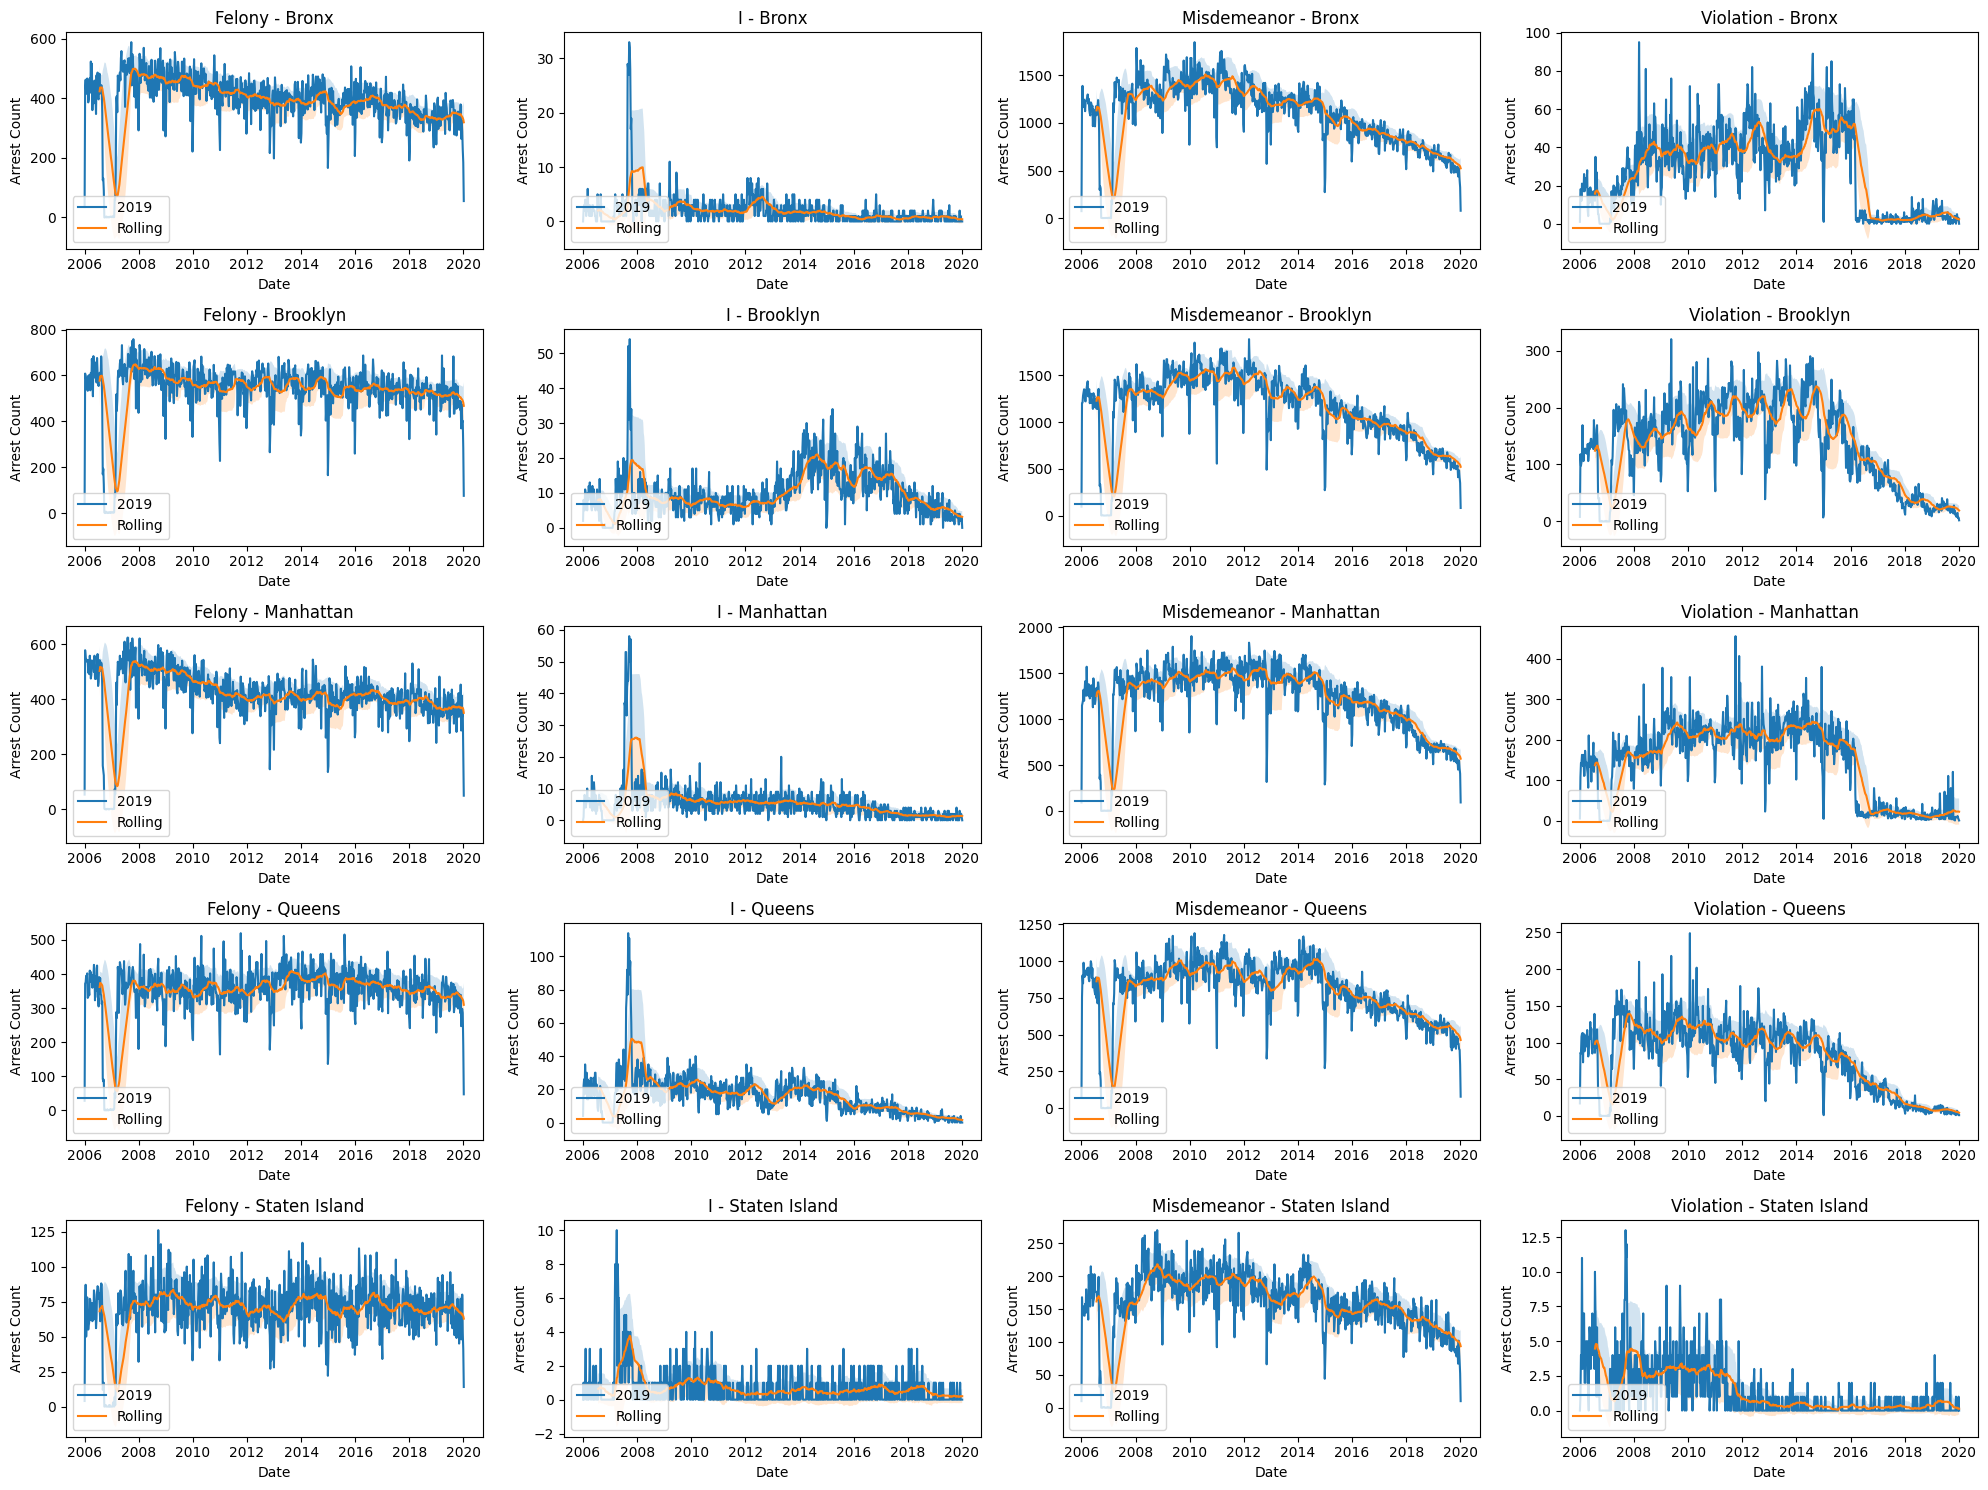

In [25]:
# Set the window size for the rolling statistics
window = 30 # Adjust the window size as needed

# Get the unique boroughs and law categories
boroughs = train_arrest_pivot.columns.get_level_values('ARREST_BORO').unique()
law_categories = train_arrest_pivot.columns.get_level_values('LAW_CAT_CD').unique()

# Calculate the number of rows and columns for subplots
num_rows = len(boroughs)
num_cols = len(law_categories)

# Create a figure and axes for subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 15))

# Iterate over each borough and law category in train_arrest_pivot
for i, borough in enumerate(boroughs):
    for j, law_cat_cd in enumerate(law_categories):
        # Extract the data for the specific borough and law category
        data = train_arrest_pivot.xs((law_cat_cd, borough), level=('LAW_CAT_CD', 'ARREST_BORO'), axis=1)
        
        # Calculate rolling mean and rolling standard deviation
        rolling_mean = data.rolling(window=window).mean()
        rolling_std = data.rolling(window=window).std()
        
        rolling_mean_values = rolling_mean.values
        rolling_std_values = rolling_std.values
        
        # Plot the original data and rolling statistics in the corresponding subplot
        axs[i, j].plot(data, label='2019')
        axs[i, j].plot(rolling_mean, label='Rolling')
        # axs[i, j].plot(rolling_std+rolling_mean, label='Rolling Std')
        axs[i, j].set_title(f'{law_cat_cd} - {borough}')
        axs[i, j].set_xlabel('Date')
        axs[i, j].set_ylabel('Arrest Count')
        axs[i, j].fill_between(data.index, rolling_mean_values.flatten(), (rolling_std_values + rolling_mean_values).flatten(), alpha=0.2)
        axs[i, j].fill_between(data.index, rolling_mean_values.flatten(), (rolling_mean_values - rolling_std_values).flatten(), alpha=0.2)
        
        axs[i, j].legend(loc='lower left')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


#### Seasonability

##### Seasonal Decomposition

### Buscando los modelos

### SARIMAX


In [ ]:
#%pip install pmdarima

In [30]:
import pmdarima as pm

auto_train_array = train_arrest_pivot.values.flatten()

model = pm.auto_arima(
    auto_train_array, 
    seasonal=True, 
    m=4, 
    suppress_warnings=True,
    stepwise=True,
    error_action='ignore',
    trace=True,
    start_p=1,
    start_q=1,
    test='adf',
    max_p=3,
    max_q=3,)

print(model.summary())

best_order = model.order
best_seasonal_order = model.seasonal_order


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[4] intercept   : AIC=206412.821, Time=4.69 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=219351.647, Time=0.15 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=207202.009, Time=4.56 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=210322.326, Time=6.20 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=225987.215, Time=0.08 sec
 ARIMA(1,0,1)(0,0,1)[4] intercept   : AIC=206412.354, Time=3.72 sec
 ARIMA(1,0,1)(0,0,0)[4] intercept   : AIC=208037.869, Time=2.26 sec
 ARIMA(1,0,1)(0,0,2)[4] intercept   : AIC=206409.771, Time=6.75 sec
 ARIMA(1,0,1)(1,0,2)[4] intercept   : AIC=206407.280, Time=8.37 sec
 ARIMA(1,0,1)(2,0,2)[4] intercept   : AIC=200870.829, Time=19.57 sec
 ARIMA(1,0,1)(2,0,1)[4] intercept   : AIC=206404.348, Time=7.68 sec
 ARIMA(0,0,1)(2,0,2)[4] intercept   : AIC=204659.428, Time=15.29 sec
 ARIMA(1,0,0)(2,0,2)[4] intercept   : AIC=201239.011, Time=14.29 sec
 ARIMA(2,0,1)(2,0,2)[4] intercept   : AIC=inf, Time=22.63 sec
 ARIMA(1

c:\Users\n3mes\miniconda3\envs\DataScience\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\n3mes\miniconda3\envs\DataScience\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\n3mes\miniconda3\envs\DataScience\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\n3mes\miniconda3\envs\DataScience\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\n3mes\miniconda3\envs\DataScience\Lib\site-packages\statsmodels\tsa\base\tsa_model.

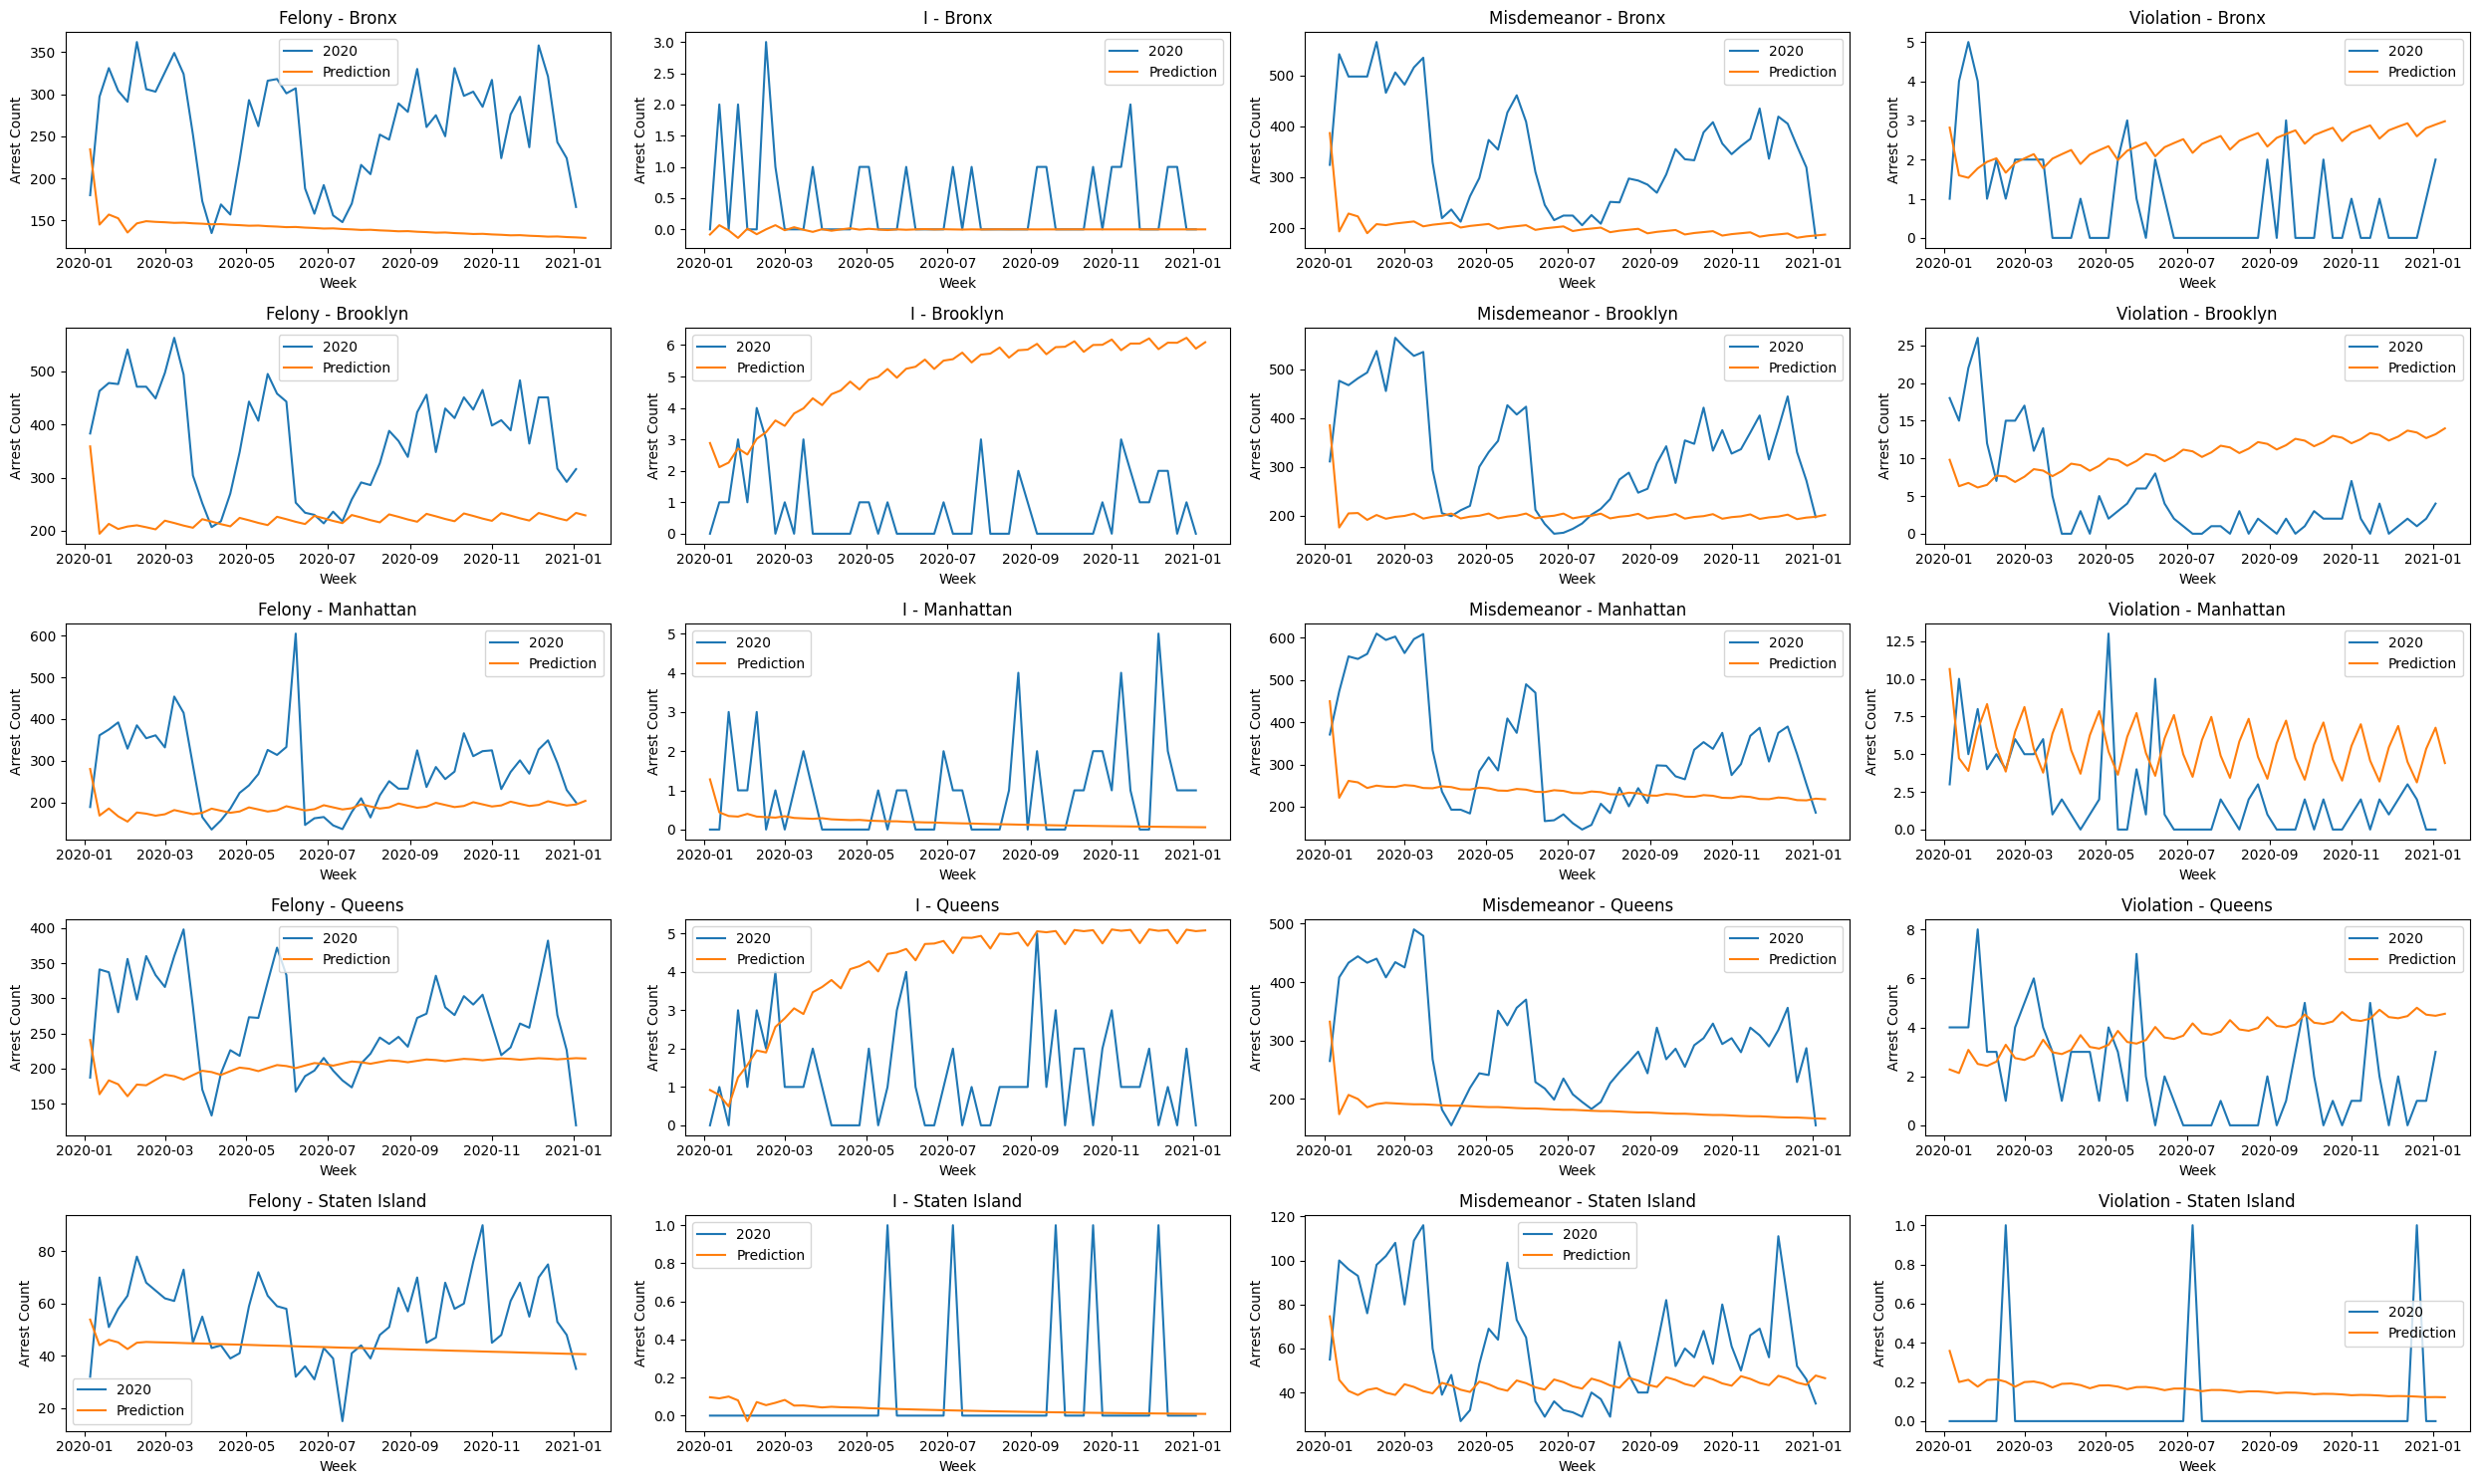

In [31]:
fig, axs = plt.subplots(len(train_arrest_pivot.columns.get_level_values('ARREST_BORO').unique()), len(train_arrest_pivot.columns.get_level_values('LAW_CAT_CD').unique()), figsize=(25, 15))


# Iterate over each borough and law category in train_arrest_pivot
for i, borough in enumerate(train_arrest_pivot.columns.get_level_values('ARREST_BORO').unique()):
    for j, law_cat_cd in enumerate(train_arrest_pivot.columns.get_level_values('LAW_CAT_CD').unique()):
        # Prepare the data for the specific borough and law category
        data = train_arrest_pivot.xs((law_cat_cd, borough), level=('LAW_CAT_CD', 'ARREST_BORO'), axis=1)
        test = test_arrest_pivot.xs((law_cat_cd, borough), level=('LAW_CAT_CD', 'ARREST_BORO'), axis=1)
        
        # Fit the SARIMA model with the best order and seasonal order to the data
        model = sm.tsa.SARIMAX(data, order=best_order, seasonal_order=best_seasonal_order)
        model_fit = model.fit()
        
        # Make predictions using index positions
        predictions = model_fit.predict(start="2020-01-05", end="2021-01-06")
        
        prediction_series = pd.Series(predictions, index=predictions.index)
        
        #axs[i,j].plot(data, label='2019')
        axs[i,j].plot(test, label='2020')
        axs[i,j].plot(prediction_series, label='Prediction')
        axs[i,j].legend()
        # axs[i,j].xticks(test.index.month)
        axs[i,j].set_xlabel('Week')
        axs[i,j].set_ylabel('Arrest Count')
        axs[i,j].set_title(f'{law_cat_cd} - {borough}')

plt.tight_layout()
plt.show()
        


### PROPHET

In [ ]:
%pip install prophet

Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [ ]:
train_arrest_pivot #! Solo la estoy usando para debuggear

LAW_CAT_CD  Felony                                                I         \
ARREST_BORO  Bronx Brooklyn Manhattan Queens Staten Island Brooklyn Queens   
ARREST_DATE                                                                  
2006-01-01    35.0     43.0      54.0   28.0           4.0      2.0    4.0   
2006-01-08   438.0    608.0     579.0  372.0          71.0      8.0   22.0   
2006-01-15   462.0    597.0     552.0  376.0          87.0      7.0   26.0   
2006-01-22   415.0    581.0     541.0  395.0          50.0      5.0   17.0   
2006-01-29   445.0    579.0     541.0  390.0          62.0     11.0   35.0   
...            ...      ...       ...    ...           ...      ...    ...   
2019-12-08   327.0    474.0     414.0  293.0          54.0      3.0    0.0   
2019-12-15   289.0    397.0     337.0  298.0          80.0      2.0    4.0   
2019-12-22   228.0    402.0     357.0  286.0          53.0      2.0    0.0   
2019-12-29   184.0    283.0     196.0  189.0          41.0      3.0    0.0   
2020-01-05    55.0     75.0      50.0   47.0          14.0      0.0    0.0   

LAW_CAT_CD  Misdemeanor                                         Violation  \
ARREST_BORO       Bronx Brooklyn Manhattan Queens Staten Island     Bronx   
ARREST_DATE                                                                 
2006-01-01         74.0     96.0      91.0   77.0          10.0       1.0   
2006-01-08       1183.0   1204.0    1149.0  754.0         168.0      18.0   
2006-01-15       1389.0   1208.0    1175.0  903.0         145.0      18.0   
2006-01-22       1167.0   1285.0    1208.0  849.0         147.0      12.0   
2006-01-29       1203.0   1318.0    1320.0  989.0         154.0      21.0   
...                 ...      ...       ...    ...           ...       ...   
2019-12-08        526.0    484.0     552.0  438.0         102.0       5.0   
2019-12-15        499.0    484.0     546.0  402.0          88.0       2.0   
2019-12-22        400.0    405.0     461.0  397.0          71.0       2.0   
2019-12-29        324.0    349.0     405.0  295.0          52.0       3.0   
2020-01-05         78.0     82.0      92.0   78.0          10.0       0.0   

LAW_CAT_CD                                I                          \
ARREST_BORO Brooklyn Manhattan Queens Bronx Manhattan Staten Island   
ARREST_DATE                                                           
2006-01-01       8.0       6.0   17.0   0.0       0.0           0.0   
2006-01-08     118.0     108.0   86.0   2.0       1.0           1.0   
2006-01-15      98.0     143.0   85.0   3.0       6.0           0.0   
2006-01-22     104.0     143.0  108.0   2.0       8.0           1.0   
2006-01-29     120.0     163.0  112.0   4.0       7.0           1.0   
...              ...       ...    ...   ...       ...           ...   
2019-12-08      14.0       9.0    7.0   0.0       1.0           1.0   
2019-12-15      15.0      12.0    5.0   1.0       1.0           0.0   
2019-12-22       6.0       8.0    2.0   0.0       2.0           0.0   
2019-12-29       7.0       4.0    1.0   0.0       1.0           0.0   
2020-01-05       2.0       1.0    1.0   0.0       0.0           0.0   

LAW_CAT_CD      Violation  
ARREST_BORO Staten Island  
ARREST_DATE                
2006-01-01            0.0  
2006-01-08            1.0  
2006-01-15            4.0  
2006-01-22            4.0  
2006-01-29           11.0  
...                   ...  
2019-12-08            0.0  
2019-12-15            0.0  
2019-12-22            0.0  
2019-12-29            1.0  
2020-01-05            0.0  

[732 rows x 20 columns]

In [ ]:
%pip install prophet==0.9.1

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement prophet==0.9.1 (from versions: 0.1.1.post1, 1.0, 1.0.1, 1.1, 1.1.1, 1.1.2, 1.1.3, 1.1.4)
ERROR: No matching distribution found for prophet==0.9.1


In [ ]:
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly


# Example for modeling arrests for Violation offenses in Queens
data = train_arrest_pivot.xs(("Violation", "Queens"), level=('LAW_CAT_CD', 'ARREST_BORO'), axis=1)

# Prepare the data in a Prophet-compatible format
df = pd.DataFrame({'ds': data.index, 'y': data.values.ravel()})

# Fit the Prophet model
model = Prophet()
model.fit(df)

# Make future predictions
future_dates = pd.date_range(start='2020-01-01', end='2020-12-01', freq='W')
future = pd.DataFrame({'ds': future_dates})
forecast = model.predict(future)


AttributeError: 'Prophet' object has no attribute 'stan_backend'

Tareas:
- Ver si con plotly puedo comparar con la data original
- Hacer un plotly iterativo x cada borough x law_cat_cd
- 

In [ ]:

plot_plotly(model,forecast)
# plot_components_plotly(model, forecast)

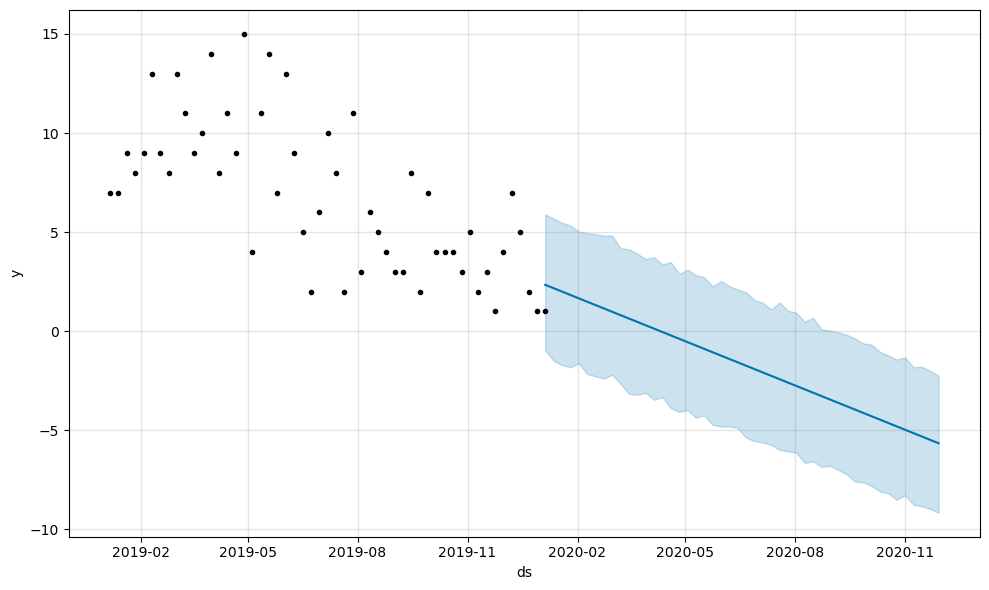

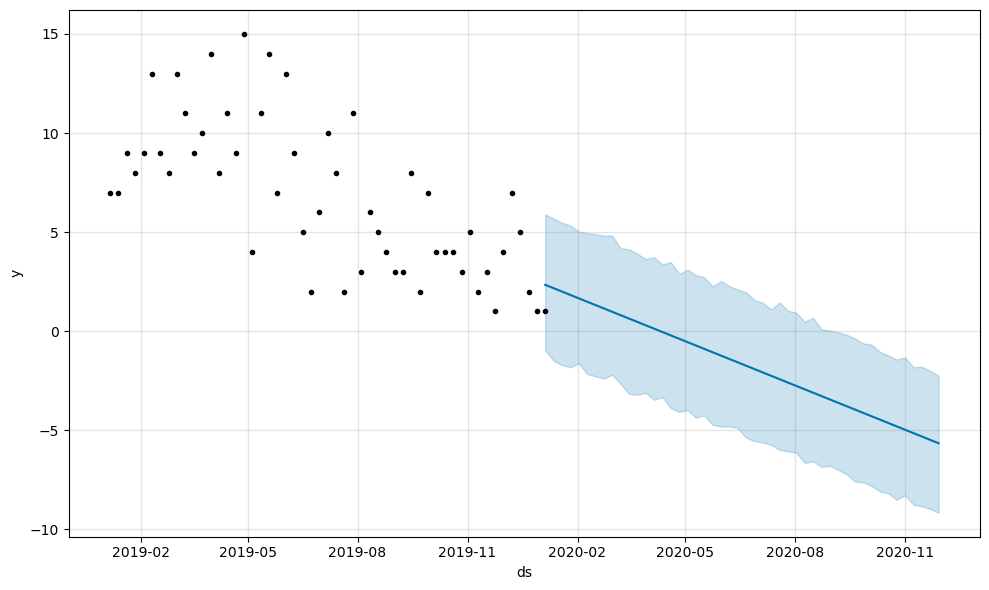

In [ ]:
model.plot(forecast)


### Auto-Arima

In [ ]:
%pip install pmdarima

In [ ]:
import seaborn as sn
import glob
